In [2]:
import marvin
marvin.config.download = True
marvin.config.release = 'DR17'

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as sci

from marvin.tools.vacs import VACs
from astropy.io import fits
import numpy as np
from marvin.tools import Maps
from marvin.tools import Cube

from marvin import config #Needed to fix "Cube not subscriptable" when running in Sciserver
config.forceDbOff() #Needed to fix "Cube not subscriptable" when running in Sciserver

print('Marvin and Matplotlib imported. Warnings about missing paths/files are typical, so no need to be concerned')

Marvin and Matplotlib imported. Warnings about missing paths/files are typical, so no need to be concerned


In [3]:
style = {
    'lines.linewidth': 1.5,
    'font.size': 16.0,
    'axes.linewidth': 1.5,
    'axes.titlesize': 'large',
    'axes.labelsize': 'large',
    'xtick.major.size': 6,
    'xtick.minor.size': 4,
    'xtick.major.width': 1.5,
    'xtick.minor.width': 1.5,
    'xtick.major.pad': 6,
    'xtick.minor.pad': 6,
    'xtick.labelsize': 'medium',
    'ytick.major.size': 6,
    'ytick.minor.size': 4,
    'ytick.major.width': 1.5,
    'ytick.minor.width': 1.5,
    'ytick.major.pad': 6,
    'ytick.minor.pad': 6,
    'ytick.labelsize': 'medium',
    'legend.fancybox': True,
    'legend.fontsize': 'small',
    'legend.scatterpoints': 5,
    'legend.loc': 'best',
    'figure.titlesize': 'large',
}

plt.style.use(style)

In [26]:
#a function to get appropriate values for arm vs interarm spaxels
def arm_selector (mangaid, plate, ifudsgn):
    pi3D = 'https://data.sdss.org/sas/dr17/manga/spectro/pipe3d/v3_1_1/3.1.1/'+str(plate)+'/manga-'+str(plate)+'-'+str(ifudsgn)+'.Pipe3D.cube.fits.gz'
    #Getting the FITS files for Pipe3D
    hdu1 = fits.open(pi3D)
    mass = hdu1[1].data[19]
    
    #Getting the GZ3D files
    maps = marvin.tools.Maps(mangaid)
    data = maps.vacs.gz3d
    
    #selecting arm vs interarm spaxels
    galaxy = data.spiral_mask_spaxel
    arm = np.where(galaxy > 5,1,np.nan)
    interarm = np.where(galaxy < 3,1,np.nan)
    ma = mass*arm
    mi= mass*interarm
    
    #getting binned averages
    radius = maps.spx_ellcoo_r_re
    mask=np.where(np.isnan(ma),0,1)
    mask2=np.where(np.isnan(mi),0,1)
    mass_ma,radius_ma,binnumber = sci.binned_statistic(radius.value[mask!=0],ma[mask!=0],bins=10,range=[0.5,2.5])
    mass_mi,radius_mi,binnnumber = sci.binned_statistic(radius.value[mask2!=0],mi[mask2!=0],bins=10,range=[0.5,2.5])
    
    return mass_ma,radius_ma,mass_mi,radius_mi

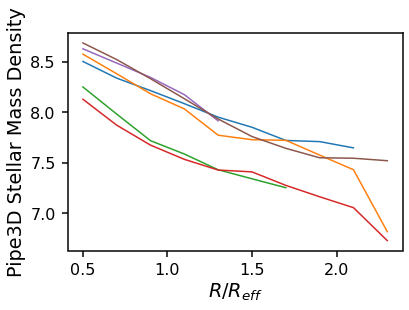

In [27]:
mangaplifu=['12514-9101', '11866-6102', '12068-6104']
plates=[12514, 11866, 12068]
ifudsgn=[9101, 6102, 6104]

mass_ma_list=[]
mass_mi_list=[]
rad_ma_list=[]
rad_mi_list=[]

plt.plot()
plt.xlabel(r'$ R/R_{eff}$')
plt.ylabel('Pipe3D Stellar Mass Density')

for i in range(len(mangaplifu)):
    mass_ma,radius_ma,mass_mi,radius_mi= arm_selector(mangaplifu[i],plates[i],ifudsgn[i])
    plt.plot(radius_ma[:-1],mass_ma,label='Average Arm Stellar Mass Density')
    plt.plot(radius_mi[:-1],mass_mi,label='Average Interarm Stellar Mass Density')
    mass_ma_list.append(mass_ma)
    mass_mi_list.append(mass_mi)
    rad_ma_list.append(radius_ma[:-1])
    rad_mi_list.append(radius_mi[:-1])

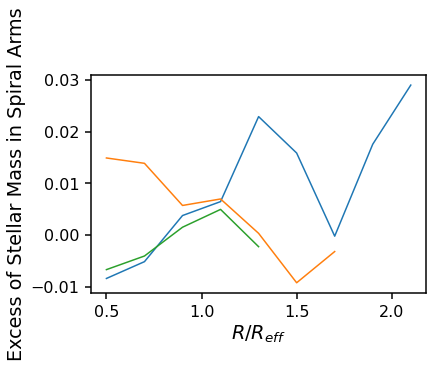

In [30]:
#log mass plot
mangaplifu=['12514-9101', '11866-6102', '12068-6104']
plates=[12514, 11866, 12068]
ifudsgn=[9101, 6102, 6104]

mass_ma_list=[]
mass_mi_list=[]
rad_ma_list=[]
rad_mi_list=[]

plt.plot()
plt.xlabel(r'$ R/R_{eff}$')
plt.ylabel('Excess of Stellar Mass in Spiral Arms')

for i in range(len(mangaplifu)):
    mass_ma,radius_ma,mass_mi,radius_mi= arm_selector(mangaplifu[i],plates[i],ifudsgn[i])
    f=((10**np.log10(mass_ma))-(10**np.log10(mass_mi)))/(10**np.log10(mass_mi))
    plt.plot(radius_mi[:-1],f)
    mass_ma_list.append(mass_ma)
    mass_mi_list.append(mass_mi)
    rad_ma_list.append(radius_ma[:-1])
    rad_mi_list.append(radius_mi[:-1])

In [18]:
m_ma=np.concatenate(mass_ma_list, axis=0)
m_mi=np.concatenate(mass_mi_list, axis=0)
r_ma=np.concatenate(rad_ma_list, axis=0)
r_mi=np.concatenate(rad_mi_list, axis=0)

#Clean out nan values because they break the next step
r_ma = r_ma[np.logical_not(np.isnan(m_ma))]
m_ma = m_ma[np.logical_not(np.isnan(m_ma))]
r_mi = r_mi[np.logical_not(np.isnan(m_mi))]
m_mi = m_mi[np.logical_not(np.isnan(m_mi))]

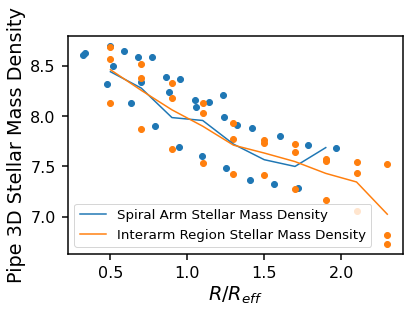

In [29]:
#a single average plot for the sample of galaxies. 

plt.scatter(r_ma,m_ma) #Use this to check where the values are which are being averaged. May not always need it.
plt.scatter(r_mi,m_mi)

meta_amass_mean,meta_aradius_mean,binnumber = sci.binned_statistic(r_ma,m_ma,bins=10,range=[0.5,2.5])
meta_imass_mean,meta_iradius_mean,binnumber = sci.binned_statistic(r_mi,m_mi,bins=10,range=[0.5,2.5])
plt.plot(meta_aradius_mean[:-1], meta_amass_mean,label='Spiral Arm Stellar Mass Density')
plt.plot(meta_iradius_mean[:-1], meta_imass_mean,label='Interarm Region Stellar Mass Density')

plt.xlabel(r'$ R/R_{eff}$')
plt.ylabel('Pipe 3D Stellar Mass Density')
plt.legend()